# **General Elections Classifier using Recurrent Neural Networks**
---
### Pavlos Dais


# **Prerequisites**

In [1]:
!pip install spacy
!python -m spacy download el_core_news_sm
!pip install optuna
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.el.300.vec.gz
!gzip -d cc.el.300.vec.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 38.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
--2024-02-10 19:19:28--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.el.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.50, 13.35.7.82, 13.35.7.38, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1256281783 (1.2G) [binary/octet-stream]
Saving to: 'cc.el.300.vec.gz'

cc.el.300.vec.gz    100%[===================>]   1.17G  30.1MB/s    in 38s     

2024-02-10 19:20:08 (31.1 MB/s) - 'cc.el.300.vec.gz' saved [1256281783/1256281783]



In [2]:
import pandas as pd
import numpy as np

# neural nets library
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# set random seed to get the same results
np.random.seed(0)
torch.manual_seed(0)
import random
random.seed(0)

torch.backends.cudnn.deterministic = True

# used for metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import auc, roc_curve

# create word embeddings
from gensim.models import Word2Vec

# optimization
import torch.optim as optim

from nltk import FreqDist
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt
import re
import optuna
from gensim.models import KeyedVectors

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import label_binarize
from itertools import cycle

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

nltk.download("omw")
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('greek'))

# avoid error at data cleaning
pd.options.mode.chained_assignment = None

import spacy
from spacy.lang.el.examples import sentences 

from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nlp = spacy.load("el_core_news_sm")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /usr/share/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Useful Code for Analysis**

In [3]:
def show_most_common(data_a, common_words_num):
    # combine all text into a single string
    text = ' '.join(data_a['Text'])

    # generate word frequencies
    word_freq = pd.Series(text.lower().split()).value_counts()

    # plot the most common words
    word_freq.head(common_words_num).plot(kind='bar', rot=45)
    plt.title(f'Top {common_words_num} Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

# **Useful Code For Data Processing**

In [4]:
# emoji to text functionality
emoji_to_text = {
    "😃": "χαρα",
    "😢": "λυπη",
    "❤️": "καρδια",
    "👍": "συμφωνω",
    "👎": "διαφωνω"
}

# replace these vowels to remove accents
vowel_replacement = {
    'ά':'α',
    'έ':'ε',
    'ή':'η',
    'ί':'ι',
    'ό':'ο',
    'ύ':'υ',
    'ώ':'ω'
}

# my stop words (not included in the nltk library)
my_stop_words = ['ειναι', 'απο', 'οτι', 'μου', 'στις', 'μας', 'της', 'την', 'τον', 'τους', 'τη', 'το', 'στους', 'στα', 'σας', 'αυτο',
                'εχει', 'μια', 'ηταν', 'μια', 'σου', 'ενα', 'αυτος', 'εγω', 'σε', 'ενας', 'ειμαι', 'εχω', 'ο']

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def translate_greek(text):
    translation_table = str.maketrans (
        'abcdefghijklmnopqrstuvwxyz',
        'αβκδεφγηιξκλμνοπθρστυϐωχυζ'
    )
    return text.translate(translation_table)

# preprocesses the tweet
def clean_tweet(tweet_str):
    
    # remove hashtags
    tweet_str = re.sub(r'#\w+', '', tweet_str)
    
    # remove @'s
    tweet_str = re.sub(r'@(\w+)', '', tweet_str)
    
    # remove urls
    tweet_str = re.sub(r'http[s]?://\S+', '', tweet_str)
    
    # remove numbers & special characters
    tweet_str = re.sub(r'[0-9]|\W', ' ', tweet_str)
    
    # remove excess tabs & white spaces
    tweet_str = re.sub(r'\s+', ' ', tweet_str).strip()
    
    # convert to lowercase for generalization
    tweet_str = tweet_str.upper()
    tweet_str = tweet_str.lower()
    
    # remove stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in stop_words])
    
    # translate english text
    tweet_str = translate_greek(tweet_str)
    
    # replace some emojies with a corresponding text and remove the rest
    for old_vowel, new_vowel in emoji_to_text.items():
        tweet_str = tweet_str.replace(old_vowel, new_vowel)
    tweet_str = re.sub(r'[\U00010000-\U0010ffff]', '', tweet_str)
    
    # lemmatization
    tweet_str = lemmatize_text(tweet_str)
    
    # remove accents
    for old_vowel, new_vowel in vowel_replacement.items(): tweet_str = tweet_str.replace(old_vowel, new_vowel)
    
    # remove my stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in my_stop_words])
    
    return tweet_str

def clean_data(text):
    return text.apply(lambda x: x.map(clean_tweet))

def print_data(text, rows):
    for i in range(rows):
        print(text.iloc[i])

def append_word(cell_value):
    return cell_value + new_word
        
def get_data(data):        
    # extract the important piece of info
    X = data[['Text']]
    Y = data[['Sentiment']]
    parties = data[['Party']]

    clean_X = clean_data(X)
    
    # add political party at the start of the tweet
    # helps to know which political party the tweet is being referred to in the training process
    for i in range(len(clean_X)):
        political_party = parties.loc[i, 'Party']
        clean_X.loc[i, 'Text'] = str(political_party) + ' ' + clean_X.loc[i, 'Text']
    
    return clean_X, Y

def get_test_data(data):
    # extract the important piece of info
    X = data[['Text']]
    parties = data[['Party']]

    clean_X = clean_data(X)
    
    # add political party at the start of the tweet
    for i in range(len(clean_X)):
        political_party = parties.loc[i, 'Party']
        clean_X.loc[i, 'Text'] = str(political_party) + ' ' + clean_X.loc[i, 'Text']
    
    return clean_X

In [5]:
def calc_scores(y_true, y_pred, train_set):
    if train_set: print("Scores for training set:")
    else:         print("Scores for validation set:")
    
    # calculate scores
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall    = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    fscore    = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    
    # show the scores
    print(f"Precision = {precision}")
    print(f"Recall    = {recall}")
    print(f"F1 score  = {fscore}\n")

def plot_results(epochs, train_scores, validation_scores, train_losses, validation_losses, y_true, y_pred, label):
    """
    This function plots the results of training (f1 score, loss learning, ROC curve).
    Parameters:
    - epochs (list): A list containing the epochs used during training.
    - train_scores (list): The train fscores during each epoch.
    - validation_scores (list): The validation scores during each epo
    - train_losses (list): The train losses during each epoch.
    - validation_losses (list): The validation losses during each epoch.
    - y_true (tensor): The actual labels.
    - y_pred (tensor): The predicited labels.
    - label (string): The title of the graph.
    Returns: Nothing
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # plot f1 score
    ax1 = axes[0]
    ax1.plot(epochs, train_scores, label="Training Score")
    ax1.plot(epochs, validation_scores, label="Validation Score")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("FScore")
    ax1.legend()
    ax1.set_title("Fscore Learning Curve")
    
    # plot cross-entropy loss
    ax2 = axes[1]
    ax2.plot(epochs, train_losses, label="Training Loss")
    ax2.plot(epochs, validation_losses, label="Validation Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Cross-Entropy Loss")
    ax2.legend()
    ax2.set_title("Loss Learning Curve")

    # plot ROC curves
    ax3 = axes[2]
    y_test = label_binarize(y_true, classes = [0, 1, 2])
    y_score = y_pred
    n_classes = 3

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # plotting ROC curves side by side
    ax3.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]))

    for i in range(n_classes):
        ax3.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
    
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylabel('True Positive Rate')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_title('ROC all classes')
    ax3.legend(loc="lower right")
    
    fig.suptitle(label, fontsize=16)
    plt.tight_layout()
    plt.show()

## **Data Processing**

Before processing:


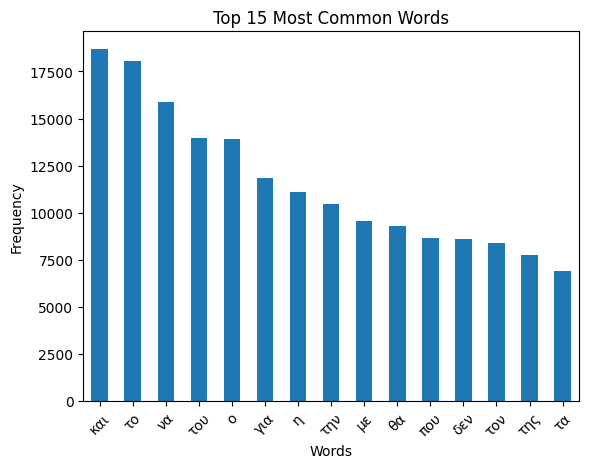

After processing:


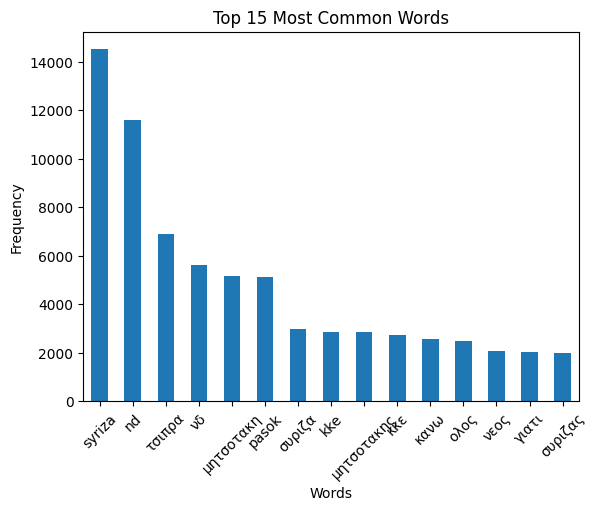

In [6]:
# read the dataframes
train_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/train_set.csv")
test_df  = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/valid_set.csv")

# plot this many number of words
common_words_num = 15

print("Before processing:")
show_most_common(train_df, common_words_num)

# convert it
train_data = get_data(train_df)
test_data  = get_data(test_df)

print("After processing:")
show_most_common(train_data[0], common_words_num)

## **Convert data**

In [7]:
def sentences_to_sequence(sentence, word_index_dict, max_length):
    sequence = np.zeros(max_length).astype(np.int32)
    tokenized_sentence = sentence.split()
    sequence_indices = list()
    for word in tokenized_sentence:
        if word in word_index_dict: sequence_indices.append(word_index_dict[word])
        else:                       sequence_indices.append(word_index_dict[''])
        
    s_size = min(max_length, len(sequence_indices))
    sequence[:s_size] = np.array(sequence_indices[:s_size])
    return sequence

def sentences_to_sequences(sentences, word_index_dict, max_length):
    """
    This function converts sentences into sequences.
    Parameters:
    - sentences (list): The list of sentences
    - word_index_dict (dict): The word to index dictionary.
    - max_length (int): The maximum size of the sequence.

    Returns:
    A sequence tensor.
    """
    
    x = np.zeros((len(sentences), max_length)).astype(np.int32)
    index = 0
    for sentence in sentences:
        x[index] = sentences_to_sequence(sentence, word_index_dict, max_length)
        index += 1
  
    return torch.from_numpy(x)

In [8]:
def get_embeddings(datafile, max_length, word_limit = 700000):
    word_dict = dict()
    i = 0
    
    # open file and extract embeddings
    with open(datafile, 'r', encoding = "utf-8") as file:
        for row in file:
            trow = row.split()
            word_dict[trow[0]] = np.array(trow[1:]).astype(np.float64)
            
            # reached word limit
            i+=1
            if (i == word_limit): break
    
    # default to zero numpoy array if we dont find the word
    word_dict[''] = np.zeros(vector_size, dtype='float')
    
    word_index       = 0
    word_index_dict  = dict()
    number_of_words  = len(word_dict)
    embeddings_array = np.zeros((number_of_words, vector_size))

    for word in word_dict:
        embeddings_array[word_index] = word_dict[word]
        word_index_dict[word]        = word_index
        word_index                   += 1

    return word_index_dict, embeddings_array, number_of_words

In [9]:
# get x values
x_train, y_train           = train_data
x_validation, y_validation = test_data
vector_size                = 300

train_sentences = [sentence for sentence in x_train['Text']]
val_sentences   = [sentence for sentence in x_validation['Text']]

In [10]:
max_length = 44
datafile = "cc.el.300.vec"

word_index_dict, embeddings_array, number_of_words = get_embeddings(datafile, max_length)
x_train      = sentences_to_sequences(train_sentences, word_index_dict, max_length)
x_validation = sentences_to_sequences(val_sentences, word_index_dict, max_length)

In [11]:
# get y values
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

y_train      = train_df[['Sentiment']]
y_validation = test_df[['Sentiment']]

y_train['Sentiment'] = y_train['Sentiment'].map(label_mapping)
y_train              = torch.tensor(y_train.values, dtype=torch.long)
y_train              = y_train.view(-1)

y_validation['Sentiment'] = y_validation['Sentiment'].map(label_mapping)
y_validation              = torch.tensor(y_validation.values, dtype=torch.long)
y_validation              = y_validation.view(-1)

# (finally) pack training, validation data together
train_d       = (x_train, y_train)
validation_d  = (x_validation, y_validation)

In [12]:
def calculate_pred(model, x_data):
    model.eval()
    y_pred = model(x_data)
    proba = F.softmax(y_pred, dim=1)
    return y_pred, proba, proba.argmax(dim=1)

# the number of epochs allowed with no improvements
epoch_limit = 3
def train_model(train_data, val_data, model, loss_function, optimizer, batch_size, epochs_num, clip_grad):
    """
    This function trains a pytorch model on a specific number of epochs and batch size.
    Parameters:
    - train_data (tuple): The train data(x,y).
    - val_data (tuple): The validation data(x,y).
    - model: The model we will be training.
    - loss_function: The loss function we will be using during training.
    - optimizer: The optimizer we will be using during training.
    - batch_size: The number of batches our data we will be divided into.
    - epochs_num(int): The number of epochs that will take place.
    - clip_grad(bool): Whether to perform gradient clippint or not.

    Returns:
    The fscore, loss values for both train and validation data. More specifically: 
    training scores (list), training losses (list), validation scores (list), validation losses (list), epochs (list), model
    """
    
    # extract train/ validation data
    # and create a dataloader to store it
    x_tr, y_tr   = train_data
    x_val, y_val = val_data
    dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
    dload   = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # save fscore/loss values
    tr_scores  = list()
    tr_losses  = list()
    val_scores = list()
    val_losses = list()
    
    min_val_loss = np.Inf
    num_of_epochs = epochs_not_improved = 0

    for epoch in range(epochs_num):
        batch_scores = list()
        batch_losses = list()
    
        # current epoch train
        model.train()
        for x_batch, y_batch in dload:
            # reset old gradients and forward pass
            optimizer.zero_grad()
            y_pred = model(x_batch)
            
            # calculate scores
            loss = loss_function(y_pred, y_batch)
            batch_losses.append(loss.item())
            prob = F.softmax(y_pred, dim=1)
            y_pred = prob.argmax(dim=1)
            batch_scores.append(f1_score(y_batch, y_pred, average='weighted'))
            
            # backpropagate using this epoch's loss
            # then update the weights
            loss.backward()
            if clip_grad: nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            
            optimizer.step()
        
        y_val_pred, y_probs, y_val_label_pred = calculate_pred(model, x_val)
        
        # update scores
        loss = loss_function(y_val_pred, y_val).item()
        tr_losses.append(sum(batch_losses)/len(dload))
        tr_scores.append(sum(batch_scores)/len(dload))
        val_losses.append(loss)
        val_scores.append(f1_score(y_val, y_val_label_pred, average='weighted'))
        
        # early stopping: if no improvements (for <epoch_limit> times) have been made exit
        num_of_epochs += 1
        if (loss < min_val_loss):
            min_val_loss = loss
            epochs_not_improved = 0
        else: epochs_not_improved+=1
        
        if (epochs_not_improved == epoch_limit):
            print("Activated early stopping")
            break
    
    return tr_scores, tr_losses, val_scores, val_losses, [epoch for epoch in range(num_of_epochs)], model

# **Model Definition**
Here we define our RNN model.

In [13]:
# common code
num_classes  = 3                      # positive, negative, neutral
criterion    = nn.CrossEntropyLoss()  # default loss function
batch_size   = 64                     # just a random number
cell_types   = {"GRU": nn.GRU,        # for readability purposes
                "LSTM": nn.LSTM}

In [14]:
# recurrent neural network model
class RNN(nn.Module):
    def __init__(self, rnn_cell_type, vocab_size, embedding_dim, pretrained_embeddings, hidden_size, num_classes, num_rnn_layers, dropout_rate):
        super().__init__()
        
        # embedding layer to convert input indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # initialize embedding weights with pre-trained vectors and make them non-trainable
        self.embedding.weight               = nn.Parameter(torch.tensor(pretrained_embeddings, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        # RNN cell (LSTM or GRU) for sequence modeling
        self.rnn_cell = cell_types[rnn_cell_type](embedding_dim, hidden_size, num_rnn_layers, bias=True, batch_first=True, dropout=dropout_rate, bidirectional=True)
        
        # fully connected layer to map RNN output to class scores
        self.fc_out = nn.Linear(2 * hidden_size, num_classes)
        
        # dropout layer to prevent overfitting
        # store some configuration parameters for future reference
        self.dropout        = nn.Dropout(dropout_rate)
        self.num_rnn_layers = num_rnn_layers
        self.rnn_cell_type  = rnn_cell_type

    def forward(self, input_sequence):
        # input sequence embedding
        embedded_input = self.embedding(input_sequence)
        
        # forward pass through the RNN cell
        if self.rnn_cell_type == "GRU": rnn_output, final_hidden_state = self.rnn_cell(embedded_input)
        else:                           rnn_output, (final_hidden_state, final_cell_state) = self.rnn_cell(embedded_input)
        
        # take the last time step's output and pass it through the fully connected layer
        return self.fc_out(rnn_output[:, -1, :])

In [15]:
# recurrent neural network model with skip connections
class skip_RNN(nn.Module):
    def __init__(self, rnn_cell_type, vocab_size, embedding_dim, pretrained_embeddings, hidden_size, num_classes, num_rnn_layers, dropout_rate):
        super().__init__()
        
        # embedding layer with pretrained word embeddings
        self.embedding                      = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight               = nn.Parameter(torch.tensor(pretrained_embeddings, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze the embedding layer
        self.layers                         = nn.ModuleList()

        # create stacked bidirectional RNN layers
        self.layers.append(cell_types[rnn_cell_type](embedding_dim, hidden_size, 1, bias=True, batch_first=True, dropout=dropout_rate, bidirectional=True))
        for i in range(1, num_rnn_layers):
            self.layers.append(cell_types[rnn_cell_type](2 * hidden_size, hidden_size, 1, bias=True, batch_first=True, dropout=dropout_rate, bidirectional=True))

        # output layer and dropout
        self.out            = nn.Linear(2*hidden_size, num_classes)
        self.dropout        = nn.Dropout(dropout_rate)
        self.num_rnn_layers = num_rnn_layers
        self.rnn_cell_type  = rnn_cell_type

    def forward(self, x):
        # embed input sequences
        x = self.embedding(x)
        input = x
        
        # process the first RNN layer separately for LSTM
        if self.rnn_cell_type == 'GRU': output, hn = self.layers[0](input)
        else:                           output, (hn, cn) = self.layers[0](input)
        
        input = output
        
        # iterate over the remaining RNN layers with skip connections
        # store the input for skip connection
        for i in range(1, self.num_rnn_layers):
            if (i % 2 == 1): identity = input  
            
            # process the current RNN layer
            if self.rnn_cell_type == 'GRU': output, hn = self.layers[i](input)
            else:                           output, (hn, cn) = self.layers[i](input)
            
            # add skip connection if the layer index is even
            if (i % 2 == 0):                 output += identity
            
            input = output  # update the input for the next layer
        
        # return the output of the last time step for classification
        return self.out(output[:, -1, :])

# **Training Process**
Here I experiment with different models.

In [16]:
# default hyperparameters
num_layers    = 2
num_hidden    = 32
dropout_rate  = 0.5
num_epochs    = 10
learning_rate = 1e-4
clip_g        = True

# **Model 1**
RNN with default hyperparameters & GRU cell.

Scores for training set:
Precision = 0.37460463244940356
Recall    = 0.37005187005187007
F1 score  = 0.3581193409123285

Scores for validation set:
Precision = 0.3716657783920453
Recall    = 0.36716360856269115
F1 score  = 0.3564451009132121



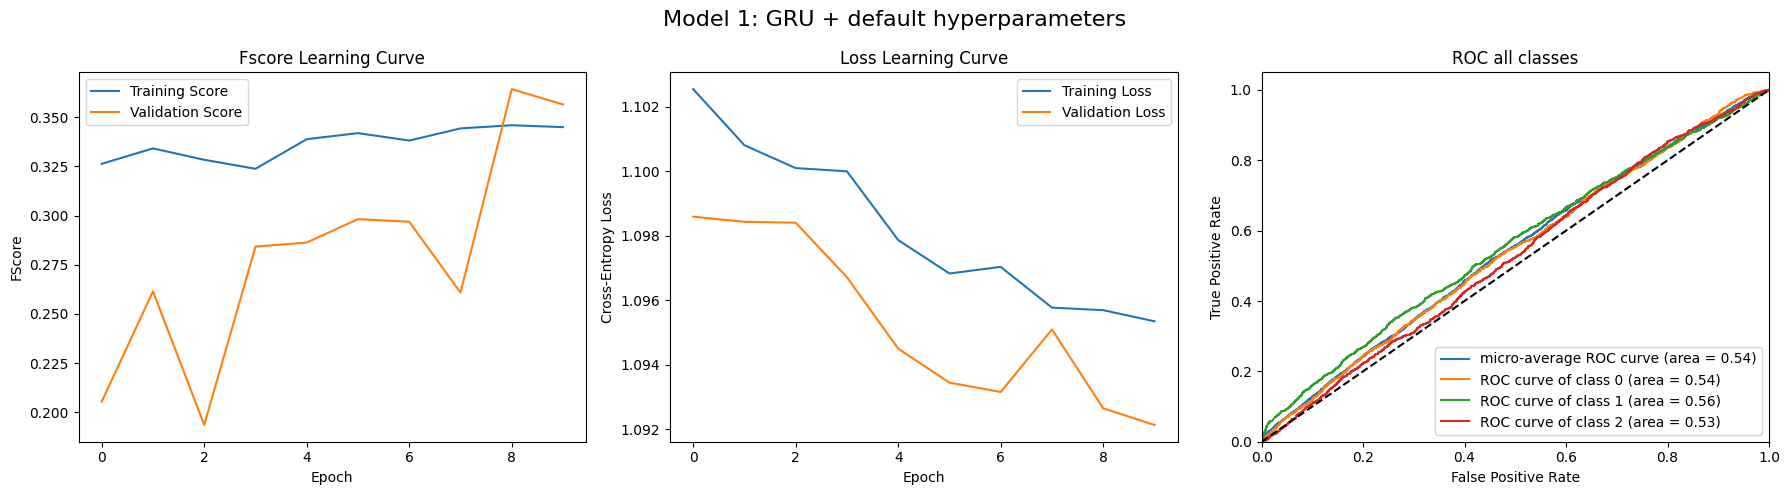

In [17]:
# hyperparameters
cell_t = "GRU"

# define model
model     = RNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Model 1: GRU + default hyperparameters")

# **Model 2**
RNN with default hyperparameters & LSTM cell.

Scores for training set:
Precision = 0.3947047912984197
Recall    = 0.3843024843024843
F1 score  = 0.36629672021245335

Scores for validation set:
Precision = 0.39165816043068596
Recall    = 0.382262996941896
F1 score  = 0.3633944271759556



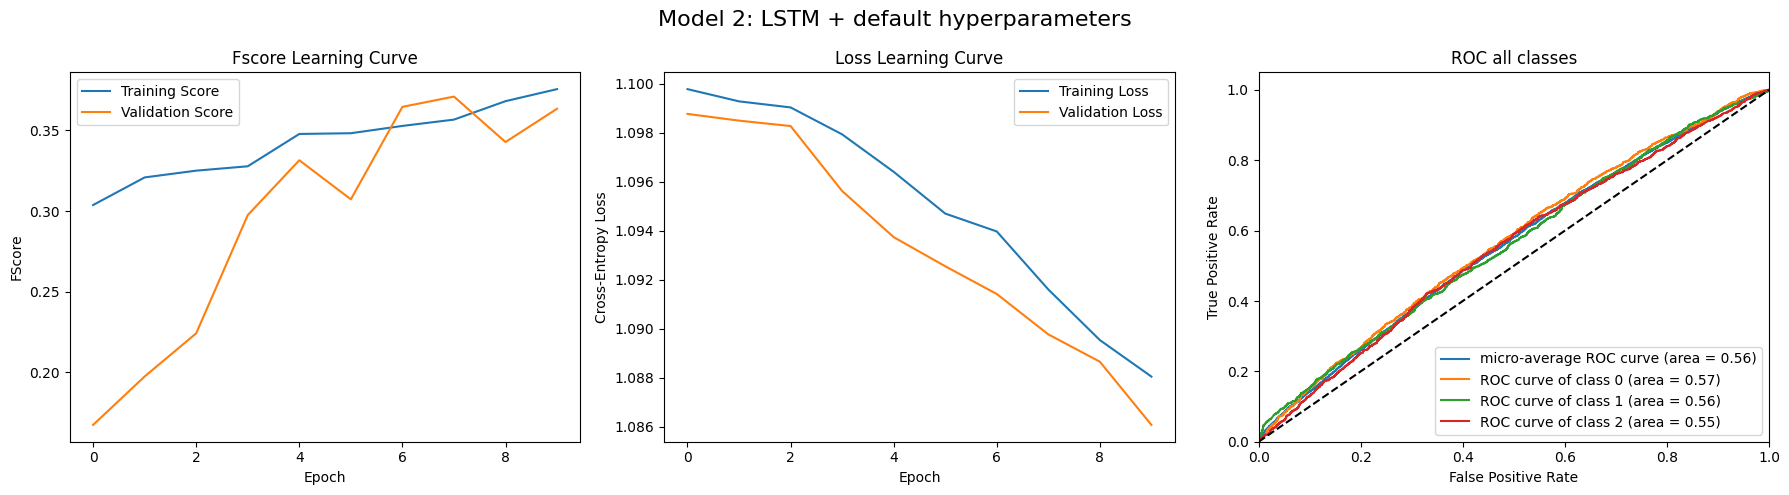

In [18]:
# hyperparameters
cell_t = "LSTM"

# define model
model     = RNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Model 2: LSTM + default hyperparameters")

# **Model 3**
RNN (skip connections) with default hyperparameters & GRU cell.

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Scores for training set:
Precision = 0.388627025259595
Recall    = 0.38244608244608247
F1 score  = 0.3554948060927642

Scores for validation set:
Precision = 0.3711984044259433
Recall    = 0.37079510703363916
F1 score  = 0.34328529561066806



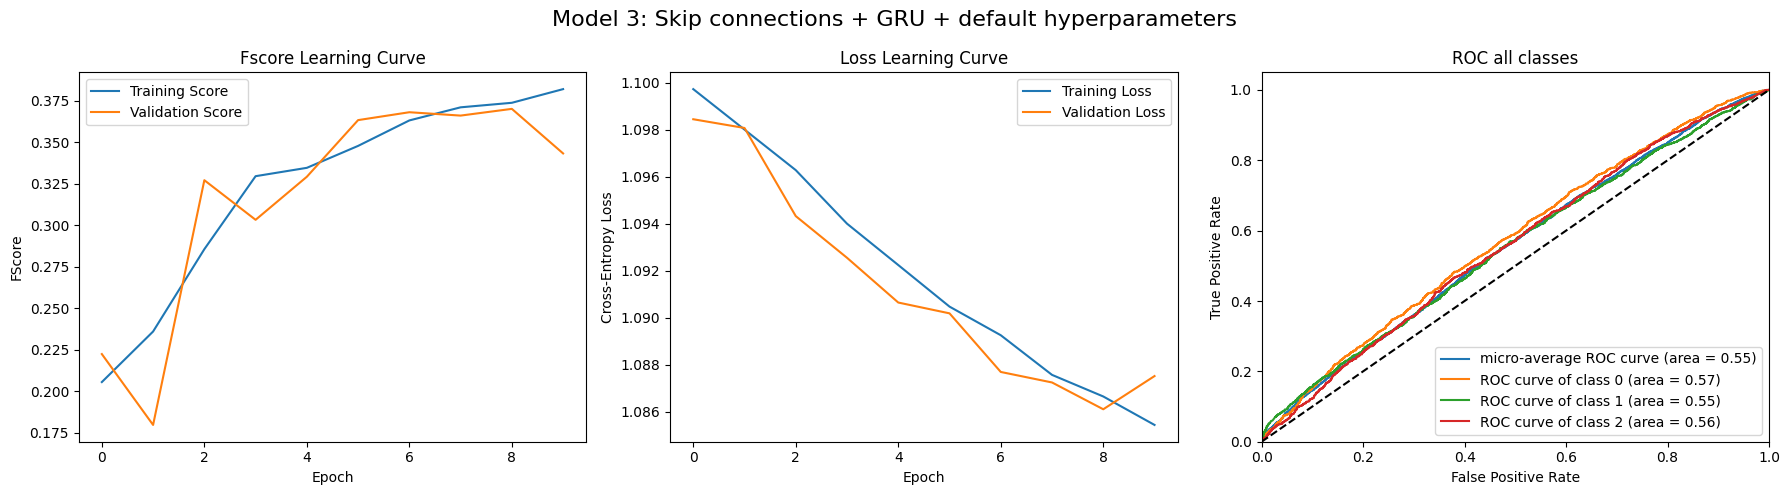

In [19]:
# hyperparameters
cell_t = "GRU"

# define model
model     = skip_RNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Model 3: Skip connections + GRU + default hyperparameters")

# **Model 4**
RNN (skip connections) with default hyperparameters & LSTM cell.

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Scores for training set:
Precision = 0.38010074060117816
Recall    = 0.3779142779142779
F1 score  = 0.3742997431238218

Scores for validation set:
Precision = 0.3805424142170579
Recall    = 0.37824923547400613
F1 score  = 0.37420699355515646



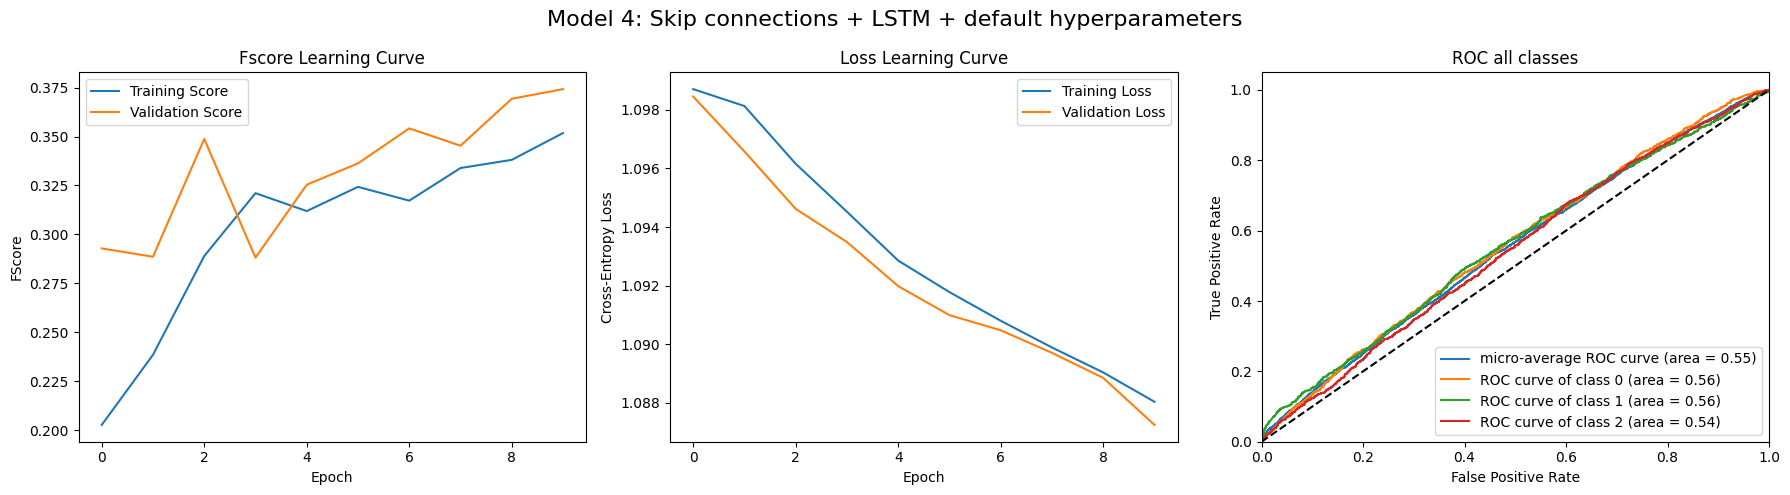

In [20]:
# hyperparameters
cell_t = "LSTM"

# define model
model     = skip_RNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)

plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Model 4: Skip connections + LSTM + default hyperparameters")

## **Running optimization**
Finally, i'll be using the optuna framework for hyperparameter optimization.

In [21]:
# default hyperparemeters settings
num_layers_range    = None
num_of_hidden_range = None
dropout_range       = None
use_lstm            = False
use_gru             = False
use_skip_conn       = False
use_gradient_clip   = None

def objective(trial):
    # optimize for:
    # 1. number of hidden layers
    # 2. type of cells
    # 3. skip connections
    # 4. gradient clipping
    # 5. dropout probability
    # 6. learning rate
    
    # number of layers & hidden
    num_layers = trial.suggest_int('num_layers', num_layers_range[0], num_layers_range[1])
    num_hidden = trial.suggest_int('num_hidden', num_of_hidden_range[0], num_of_hidden_range[1])
    
    # type of cell
    if (use_lstm):  cell_type = 'LSTM'
    elif (use_gru): cell_type = 'GRU'
    else:           cell_type = trial.suggest_categorical('cell_type', ['LSTM', 'GRU'])
    
    # skip connections
    if use_skip_conn == None:     use_skip_connections = trial.suggest_categorical('use_skip_connections', [True, False])
    elif (use_skip_conn == True): use_skip_connections = True
    else:                         use_skip_connections = False
    
    # gradient clipping
    if (use_gradient_clip == None):   gradient_clip = trial.suggest_categorical('gradient_clip', [True, False])
    elif (use_gradient_clip == True): gradient_clip = True
    else:                             gradient_clip = False
    
    # dropout probability
    dropout_rate = trial.suggest_float('dropout_rate', dropout_range[0], dropout_range[1])

    # build the model
    model = None
    if use_skip_connections: model = RNN(cell_type, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
    else:                    model = skip_RNN(cell_type, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)

    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_float('lr', 1e-5, 1e-1, log=True))
    
    # train model and get score
    _, _, _, _, _, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, gradient_clip)    
    _, _, y_train_pred = calculate_pred(model, x_train)
    return f1_score(y_train, y_train_pred, average='weighted', zero_division=1)

## **Optuna 1**

Scores for training set:
Precision = 0.4552791575196557
Recall    = 0.43933933933933933
F1 score  = 0.43325022976441174

Scores for validation set:
Precision = 0.4132739428097017
Recall    = 0.40672782874617736
F1 score  = 0.39825356772090637



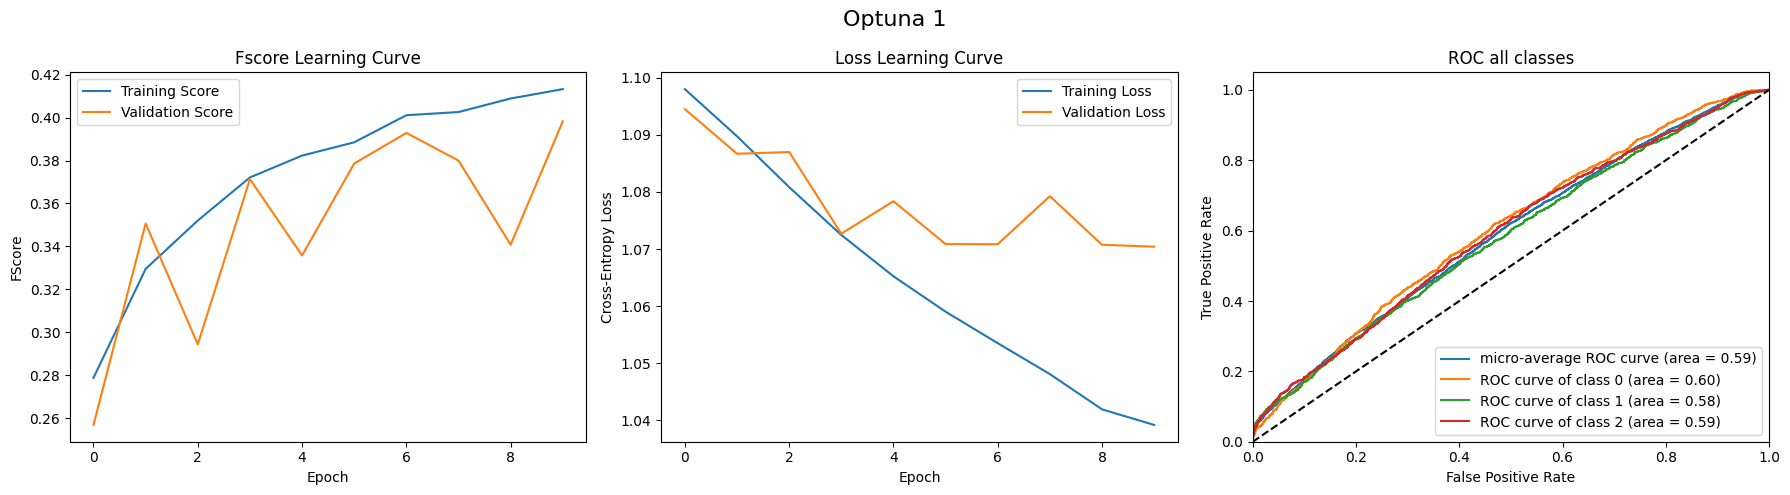

In [22]:
num_layers_range    = [2, 4]
num_of_hidden_range = [8, 30]
dropout_range       = [0, 0.5]

#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=150)

# print the best hyperparameters found
#best_params = study.best_params
#print(f"Best Hyperparameters: {best_params}")

#######################################################################
# Result of 1st run of optuna (after ~100 iterations):
#######################################################################

# hyperparameters
num_layers    = 2
num_hidden    = 27
cell_t        = "GRU"
dropout_rate  = 0.45540414695654136
num_epochs    = 10
learning_rate = 0.00732040934011655
clip_g        = True

# define model
model     = RNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Optuna 1")

# **Optuna 2**

Scores for training set:
Precision = 0.446341422075647
Recall    = 0.444963144963145
F1 score  = 0.4395402228197163

Scores for validation set:
Precision = 0.4074967510118108
Recall    = 0.40615443425076453
F1 score  = 0.40102608688979213



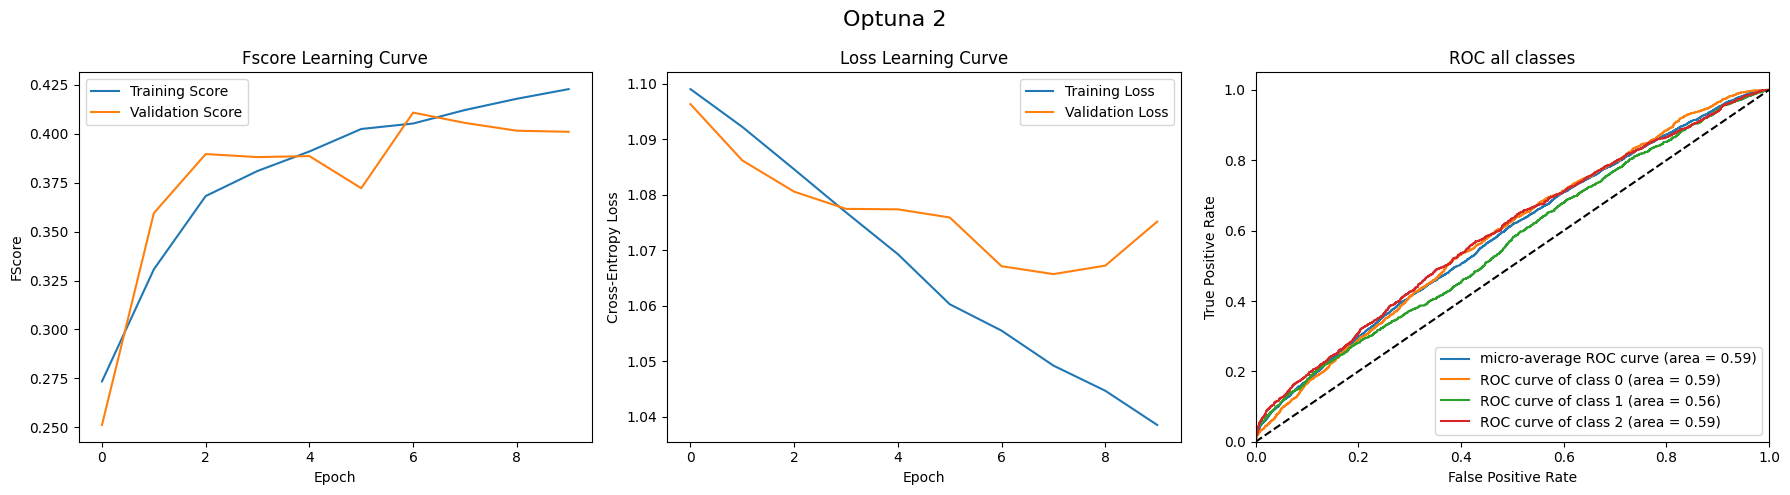

In [23]:
# we narrow down the search to around these parameters
# [2, 3] number of layers
# [20, 30] dropout range
# [0.25, 0.5] dropout range

num_layers_range    = [2, 3]
num_of_hidden_range = [20, 30]
dropout_range       = [0.25, 0.5]
use_gradient_clip   = True
use_gru             = True
use_skip_conn       = False

#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=150)

# print the best hyperparameters found
#best_params = study.best_params
#print(f"Best Hyperparameters: {best_params}")

#######################################################################
# Result of 2nd run of optuna (after ~100 iterations):
#######################################################################

# hyperparameters
num_layers    = 3
num_hidden    = 23
cell_t        = "GRU"
dropout_rate  = 0.33987276900109276
num_epochs    = 10
learning_rate = 0.0036023101778282778
clip_g        = True

# define model
model     = RNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Optuna 2")

# **Optuna 3**

Activated early stopping
Scores for training set:
Precision = 0.4576728935695917
Recall    = 0.4386022386022386
F1 score  = 0.41818067986029983

Scores for validation set:
Precision = 0.41727203313458533
Recall    = 0.40615443425076453
F1 score  = 0.3851573212778315



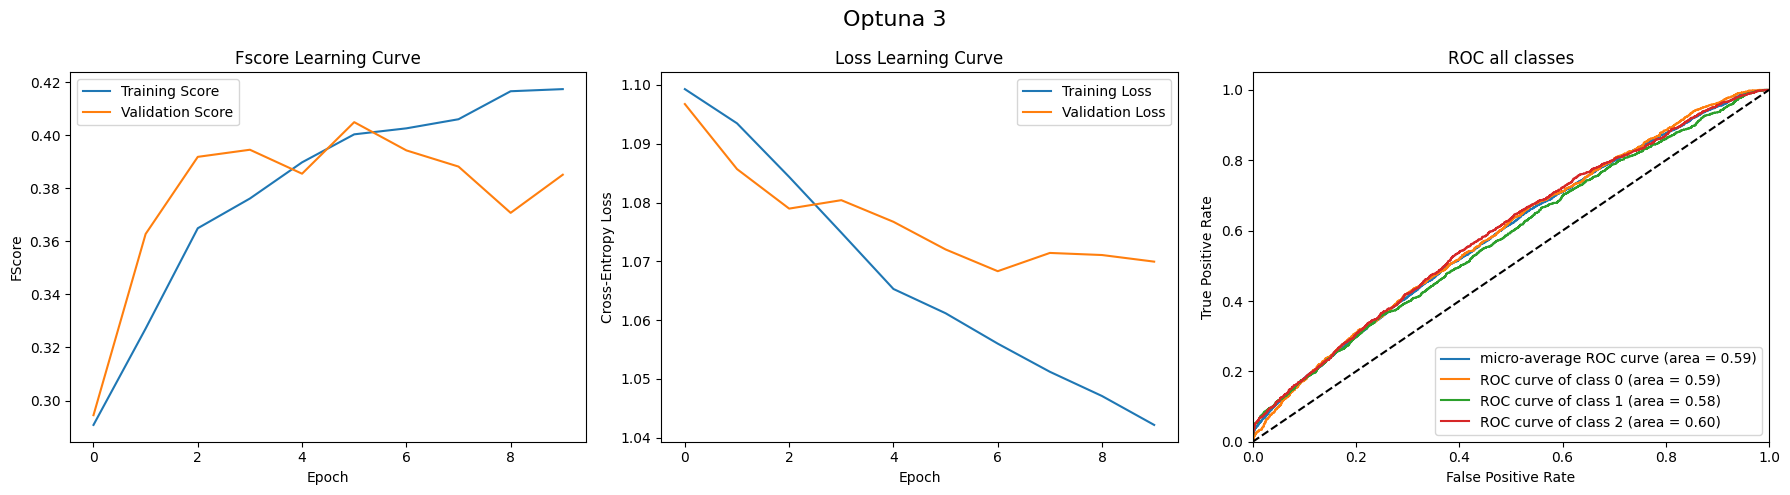

In [24]:
# we narrow down the search to around these parameters
# 3 number of layers
# [20, 30] dropout range
# [0.25, 0.4] dropout range

num_layers_range    = [3, 3]
num_of_hidden_range = [25, 30]
dropout_range       = [0.25, 0.4]
use_gradient_clip   = True
use_gru             = True
use_skip_conn       = False

#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=150)

# print the best hyperparameters found
#best_params = study.best_params
#print(f"Best Hyperparameters: {best_params}")

#######################################################################
# Result of 3rd run of optuna (after ~70 iterations):
#######################################################################

# hyperparameters
num_layers    = 3
num_hidden    = 29
cell_t        = "GRU"
dropout_rate  = 0.3617334296165072
num_epochs    = 10
learning_rate = 0.0031120036241028934
clip_g        = True

# define model
model     = RNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Optuna 3")

# **Final Model**
Here's my final model.

Activated early stopping
Scores for training set:
Precision = 0.4385931704206795
Recall    = 0.4376194376194376
F1 score  = 0.4342432098555485

Scores for validation set:
Precision = 0.4016790493626359
Recall    = 0.40214067278287463
F1 score  = 0.398845747549527



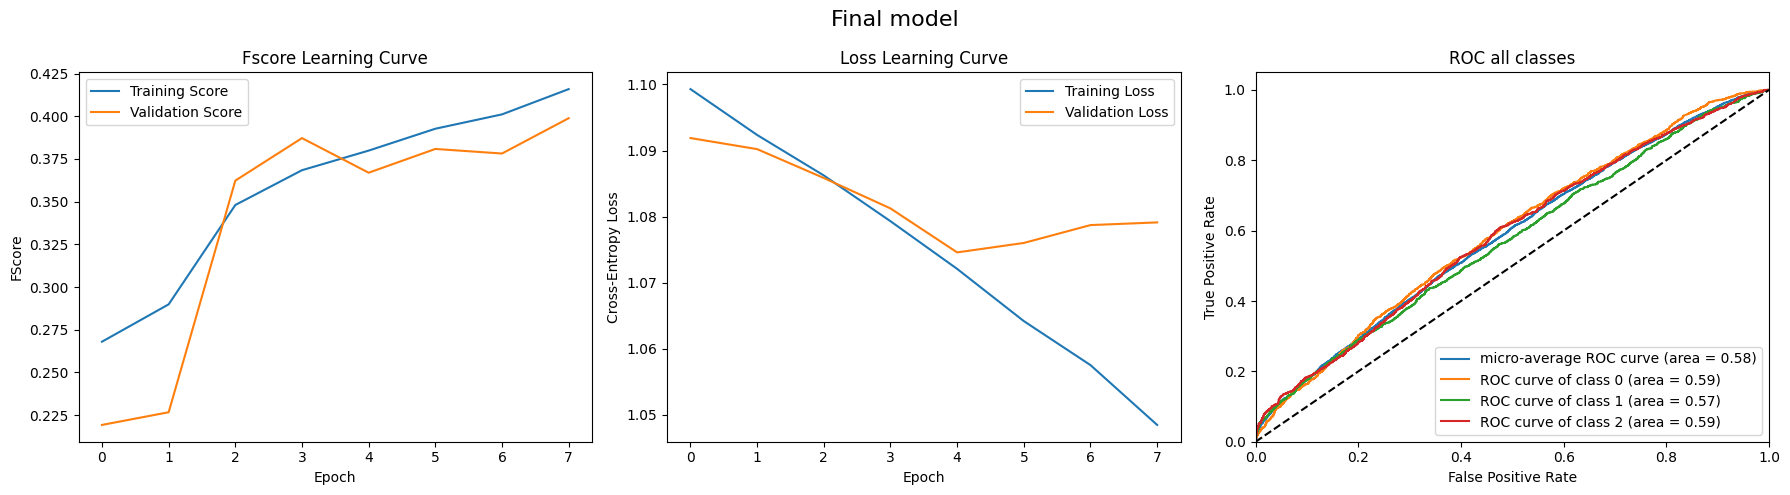

In [25]:
# hyperparameters
num_layers    = 3
num_hidden    = 29
cell_t        = "GRU"
dropout_rate  = 0.3617334296165072
num_epochs    = 10
learning_rate = 0.0031120036241028934
clip_g        = True

# define (final) model
final_model = RNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer   = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, final_model = train_model(train_d, validation_d, final_model,
                                                                                criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(final_model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(final_model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Final model")

# **Attention**
At last, I'll add attention to my final model.

In [26]:
# recurrent neural network model using attention
class AttentionRNN(nn.Module):
    def __init__(self, rnn_cell_type, vocab_size, embedding_dim, pretrained_embeddings, hidden_size, num_classes, num_rnn_layers, dropout_rate):
        super().__init__()
        
        # number of RNN layers & type of cell
        self.num_layers = num_rnn_layers
        self.cell_type  = rnn_cell_type
        
        # softmax layer for attention weights
        self.softmax   = nn.Softmax(dim=1)
        self.tanh      = nn.Tanh()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # initialize embedding weights with pre-trained vectors and make them non-trainable
        self.embedding.weight               = nn.Parameter(torch.tensor(pretrained_embeddings, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        # RNN cell (LSTM or GRU) for sequence modeling
        self.cell = cell_types[rnn_cell_type](embedding_dim, hidden_size, num_rnn_layers, bias=True,
                                              batch_first=True, dropout=dropout_rate, bidirectional=True)
        
        # linear layer for attention mechanism
        self.attention = nn.Linear(2 * hidden_size, 1, bias=True)
        
        # fully connected layer to map RNN output to class scores
        self.out = nn.Linear(2 * hidden_size, num_classes)
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_sequence):
        embedded_input = self.embedding(input_sequence)
        
        # Forward pass through the RNN cell
        if self.cell_type == 'GRU': output, hn = self.cell(embedded_input)
        else:                       output, (hn, cn) = self.cell(embedded_input)
            
        # compute attention weights
        attention_weights = self.tanh(self.attention(output))
        attention_weights = self.softmax(attention_weights)
        
        # apply attention mechanism
        output = output * attention_weights
        output = torch.sum(output, dim=1)
        
        # map the output to class scores
        return self.out(output)

Activated early stopping
Scores for training set:
Precision = 0.4599390682873873
Recall    = 0.4485121485121485
F1 score  = 0.4386784884876997

Scores for validation set:
Precision = 0.40897128840940944
Recall    = 0.40271406727828746
F1 score  = 0.39264675294618495



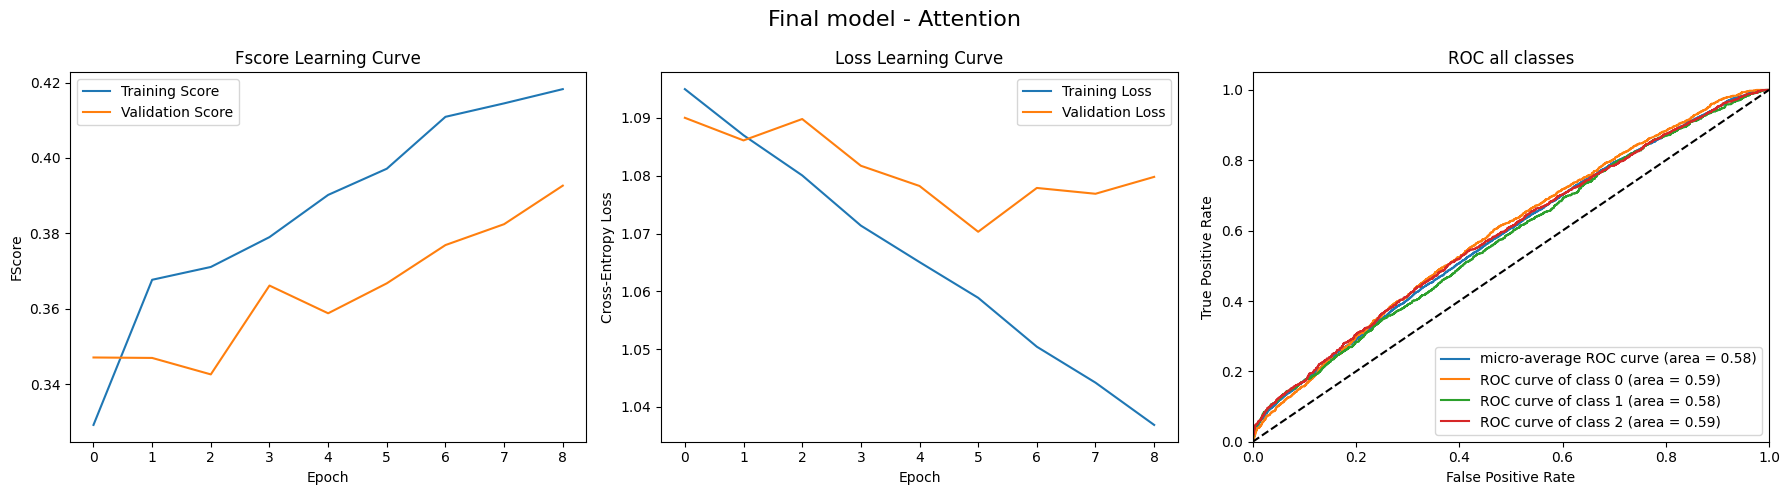

In [27]:
# define (attention) model
model     = AttentionRNN(cell_t, number_of_words, vector_size, embeddings_array, num_hidden, num_classes, num_layers, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, model = train_model(train_d, validation_d, model, criterion, optimizer, batch_size, num_epochs, clip_g)

# print results
_, _, y_train_pred = calculate_pred(model, x_train)
calc_scores(y_train, y_train_pred, True)

_, y_probs, y_validation_pred = calculate_pred(model, x_validation)
calc_scores(y_validation, y_validation_pred, False)
    
plot_results(epochs, tr_scores, val_scores, tr_losses, val_losses, y_validation, y_probs.detach().numpy(), "Final model - Attention")

# **Final Submission**

In [28]:
test_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/test_set.csv") 
test_data = get_test_data(test_df)

In [29]:
test_sentences = [sentence for sentence in test_data['Text']]
x_test         = sentences_to_sequences(test_sentences, word_index_dict, max_length)

# calculate predictions
_, _, y_train_pred = calculate_pred(final_model, x_test)

# convert into numpy
y_train_pred_numpy = y_train_pred.numpy()

label_mapping = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
vectorized_mapping = np.vectorize(lambda x: label_mapping[x])
mapped_array = vectorized_mapping(y_train_pred_numpy)

final_df = pd.DataFrame({'Id': test_df['New_ID'], 'Predicted': mapped_array})
final_df.to_csv('output_file.csv', index=False)